In [97]:
%pip install pandas numpy scikit-learn torch

import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, f1_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

Note: you may need to restart the kernel to use updated packages.


In [98]:
!pip install torch

In [99]:
class MultiTaskDataset(Dataset):
    def __init__(self, X, y_wqi, y_quality):
        self.X = X
        self.y_wqi = y_wqi
        self.y_quality = y_quality

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], (self.y_wqi[idx], self.y_quality[idx])

In [100]:
data = pd.read_csv("water_quality.csv")

In [101]:
data.head()

,Well_ID,State,District,Block,Village,Latitude,Longitude,Year,pH,EC,...,NO3,TH,Ca,Mg,Na,K,F,TDS,WQI,Water Quality Classification
0,W232200071580001,Gujarat,Ahmedabad,Mandal,Dalod,NaN,NaN,2020,8.20,16640.0,...,26.00,1451.0,152.0,260.0,3535.0,45.0,1.00,11149,4361.44080,Unsuitable for Drinking
1,W254029084355301,Himachal Pradesh,Solan,Nallagarh,JAGATPUR,31.1594,76.678500,2019,8.44,299.0,...,2.70,84.0,17.0,10.0,39.0,2.4,0.20,262,85.80466,Good
2,W193530074180001,Maharashtra,Ahmednagar,SANGAMNER,Kokangaon,74.3000,19.591667,2022,7.90,1315.0,...,18.20,465.0,80.2,64.4,88.3,1.6,0.53,372,280.04130,Very Poor yet Drinkable
3,W231620072033001,Gujarat,Ahmedabad,Viramgam,Endla,NaN,NaN,2020,7.40,715.0,...,0.23,280.0,56.0,34.0,47.0,11.0,0.46,479,195.11649,Poor
4,W251908084361501,Himachal Pradesh,Solan,Nallagarh,BARUNA,31.1540,76.638400,2019,8.40,270.0,...,10.00,116.0,10.0,18.0,23.0,1.0,0.12,262,81.77860,Good


In [102]:
features = ['pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS']
X = data[features].values



In [103]:
# Fill missing values in the selected feature columns with their mean
data[features] = data[features].fillna(data[features].mean())


In [104]:
y_wqi = data['WQI'].values.reshape(-1,1) / 100
le = LabelEncoder()
y_quality = le.fit_transform(data['Water Quality Classification']).reshape(-1,1)

In [105]:
X_train, X_test, y_wqi_train, y_wqi_test, y_quality_train, y_quality_test = train_test_split(X, y_wqi, y_quality, test_size=0.2, random_state=42) 

In [106]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [107]:
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_wqi_train_tensor = torch.FloatTensor(y_wqi_train)
y_wqi_test_tensor = torch.FloatTensor(y_wqi_test)
y_quality_train_tensor = torch.FloatTensor(y_quality_train)
y_quality_test_tensor = torch.FloatTensor(y_quality_test)

In [108]:
train_data = MultiTaskDataset(X_train_tensor, y_wqi_train_tensor, y_quality_train_tensor)
test_data = MultiTaskDataset(X_test_tensor, y_wqi_test_tensor, y_quality_test_tensor)

In [109]:
class WaterQualityModel(nn.Module):
    def __init__(self, input_size):
        super(WaterQualityModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(64,32)
        self.dropout2 = nn.Dropout(0.3)
        self.wqi_output = nn.Linear(32,1)
        self.quality_output = nn.Linear(32, len(le.classes_))
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        x = self.relu(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu(self.layer2(x))
        x = self.dropout2(x)
        wqi = self.wqi_output(x)
        quality = self.quality_output(x)
        return wqi, quality
input_size = X_train.shape[1]


In [110]:
def train_model(model, optimizer, train_loader, X_train, y_wqi_train, y_quality_train, epochs, print_every):
    model.train()
    for epoch in range(epochs):
        total_wqi_loss = 0
        total_quality_loss = 0
        for X_batch, (y_wqi_batch, y_quality_batch) in train_loader:
            optimizer.zero_grad()
            wqi_pred, quality_pred = model(X_batch)
            loss_wqi = criterion_wqi(wqi_pred, y_wqi_batch)
            loss_quality = criterion_quality(quality_pred, y_quality_batch.squeeze(1).long()) 
            loss = loss_wqi + loss_quality
            loss.backward()
            optimizer.step()
            total_wqi_loss += loss_wqi.item()
            total_quality_loss += loss_quality.item()

        if (epoch + 1) % print_every == 0:
            model.eval()
            with torch.no_grad():
                wqi_pred_train, quality_pred_train = model(X_train)
                wqi_pred_test, quality_pred_test = model(X_test_tensor)
                train_wqi_loss = criterion_wqi(wqi_pred_train, y_wqi_train).item()
                train_quality_loss = criterion_quality(quality_pred_train, y_quality_train.squeeze(1).long()).item()
                test_wqi_loss = criterion_wqi(wqi_pred_test, y_wqi_test_tensor).item()
                test_quality_loss = criterion_quality(quality_pred_test, y_quality_test_tensor.squeeze(1).long()).item()
                print(f'Epoch [{epoch+1}/{epochs}], Train WQI Loss: {train_wqi_loss:.4f}, '
                      f'Train Quality Loss: {train_quality_loss:.4f}, '
                      f'Test WQI Loss: {test_wqi_loss:.4f}, Test Quality Loss: {test_quality_loss:.4f}')

In [111]:
def evaluate_model(model, X_test, y_wqi_test, y_quality_test):
    model.eval()
    with torch.no_grad():
        wqi_pred, quality_pred = model(X_test)
        wqi_pred_np = wqi_pred.numpy() * 100
        y_wqi_test_np = y_wqi_test.numpy() * 100
        quality_pred_np = torch.argmax(quality_pred, dim=1).numpy()
        y_quality_test_np = y_quality_test.numpy().squeeze()

        r2_wqi = r2_score(y_wqi_test_np, wqi_pred_np)
        f1_quality = f1_score(y_quality_test_np, quality_pred_np, average='weighted')
        accuracy_quality = accuracy_score(y_quality_test_np, quality_pred_np)

        return accuracy_quality, r2_wqi, f1_quality

criterion_wqi = nn.MSELoss()
criterion_quality = nn.CrossEntropyLoss()

In [112]:
gradient_types = {
    'Stochastic': {'batch_size': 1, 'epochs': 10},
    'Batch': {'batch_size': len(X_train), 'epochs': 1000},
    'Mini-Batch': {'batch_size': 64, 'epochs': 500}
}

In [113]:
for grad_type, params in gradient_types.items():
    print(f"\nUsing {grad_type} Gradient Descent")
    model = WaterQualityModel(input_size)
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)


Using Stochastic Gradient Descent

Using Batch Gradient Descent

Using Mini-Batch Gradient Descent


In [114]:
train_model(model, optimizer, train_loader, X_train_tensor, y_wqi_train_tensor, y_quality_train_tensor,
                epochs=params['epochs'], print_every=10 if params['epochs'] > 10 else 1)

Epoch [10/500], Train WQI Loss: 0.1508, Train Quality Loss: 1.1008, Test WQI Loss: 0.1663, Test Quality Loss: 1.0783
Epoch [20/500], Train WQI Loss: 0.0385, Train Quality Loss: 0.8970, Test WQI Loss: 0.0468, Test Quality Loss: 0.8752
Epoch [30/500], Train WQI Loss: 0.0273, Train Quality Loss: 0.7629, Test WQI Loss: 0.0335, Test Quality Loss: 0.7430
Epoch [40/500], Train WQI Loss: 0.0209, Train Quality Loss: 0.6602, Test WQI Loss: 0.0260, Test Quality Loss: 0.6432
Epoch [50/500], Train WQI Loss: 0.0161, Train Quality Loss: 0.5751, Test WQI Loss: 0.0204, Test Quality Loss: 0.5611
Epoch [60/500], Train WQI Loss: 0.0130, Train Quality Loss: 0.5042, Test WQI Loss: 0.0169, Test Quality Loss: 0.4928
Epoch [70/500], Train WQI Loss: 0.0109, Train Quality Loss: 0.4456, Test WQI Loss: 0.0146, Test Quality Loss: 0.4363
Epoch [80/500], Train WQI Loss: 0.0092, Train Quality Loss: 0.3977, Test WQI Loss: 0.0125, Test Quality Loss: 0.3900
Epoch [90/500], Train WQI Loss: 0.0082, Train Quality Loss: 0.35

In [115]:
accuracy , r2, f1 = evaluate_model(model, X_test_tensor, y_wqi_test_tensor, y_quality_test_tensor)

In [116]:
print(f"Results with {grad_type}:")
print(f"Accuracy (Quality Classification): {accuracy:.4f}")
print(f"R² (WQI Regression): {r2:.4f}")
print(f"F1 Score (Quality Classification): {f1:.4f}")

Results with Mini-Batch:
Accuracy (Quality Classification): 0.9785
R² (WQI Regression): 0.9999
F1 Score (Quality Classification): 0.9784


Note: you may need to restart the kernel to use updated packages.


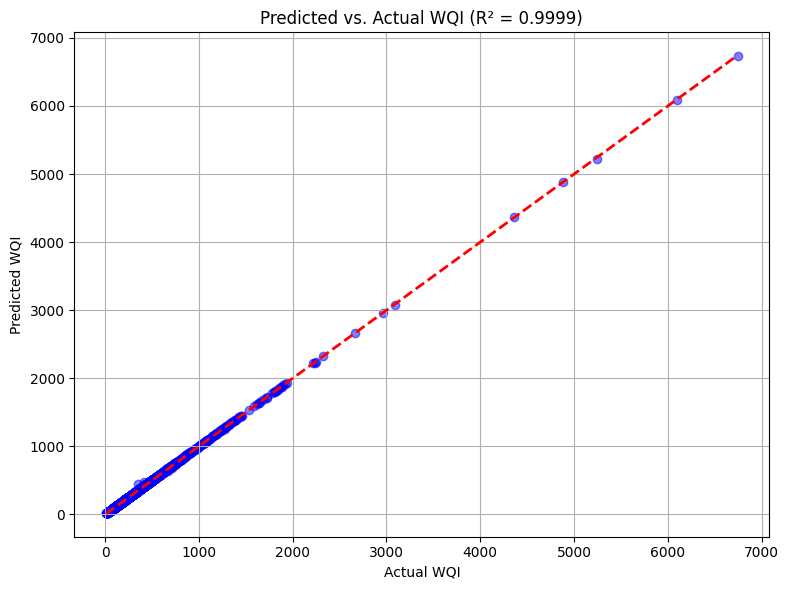

In [117]:
%pip install matplotlib
import matplotlib.pyplot as plt


model.eval()
with torch.no_grad():
    wqi_pred, _ = model(X_test_tensor)
    wqi_pred_np = wqi_pred.numpy() * 100  
    y_wqi_test_np = y_wqi_test_tensor.numpy() * 100

plt.figure(figsize=(8, 6))
plt.scatter(y_wqi_test_np, wqi_pred_np, alpha=0.5, color='blue')
plt.plot([y_wqi_test_np.min(), y_wqi_test_np.max()], [y_wqi_test_np.min(), y_wqi_test_np.max()], 'r--', lw=2) 
plt.xlabel('Actual WQI')
plt.ylabel('Predicted WQI')
plt.title('Predicted vs. Actual WQI (R² = 0.9999)')
plt.grid(True)
plt.tight_layout()


plt.show()